# Triangle Prism Densities

An example application of the `circle_bundles` pipeline to a dataset where the underlying model is a non-orientable 3-manifold which admits a circle bundle structure over $\mathbb{RP}^{2}$ with non-trivial twisted Euler class. 

Also a demonstration of the bundle-coordinatization feature of `circle_bundles` which produces a topologically-faithful lower-dimensional representation of the data. 

We generate a dataset by applying random $SO(3)$ rotations to the vertices of a triangular prism embedded in the unit ball, then constructing 3D density functions on $\overline{\mathbb{B}}_{1}(0)$ from the rotated prisms which are Gaussian-distributed around their boundaries.  For analysis, we define an $\mathbb{RP}^{2}$-valued feature map which roughly captures the axis of symmetry of each density. One can show that the underlying bundle structure is non-orientable with twisted Euler number $\pm 3$.

We recover the characteristic classes, which determines the topology of the total space up to homeomorphism (in particular, it is a quotient of $SO(3)$). We then restrict to a subset of the data which projects to an 'equator' $\mathbb{RP}^{1}\subset\mathbb{RP}^{2}$ and verify that the restriction has the structure of a Klein bottle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import circle_bundles as cb

Start by generating a synthetic dataset of 3D densities represented as vectors of length $32^{3}$. Record the corresponding triangle meshes for visualization (represented as vectors in $\mathbb{R}^{18}$):

In [2]:
#Create the template triangle mesh
mesh, face_groups = cb.make_tri_prism(height=1, radius=1)

#Generate a random sample of SO(3) matrices
n_samples = 5000
rng = np.random.default_rng(0)
so3_data = cb.sample_so3(n_samples, rng=rng)[0]

#Apply rotations to the template mesh
mesh_data = cb.get_mesh_sample(mesh, so3_data)

#Generate 3D densities from the rotated meshes
grid_size = 32  #density resolution
sigma = 0.05  #density gaussian parameter

data = cb.make_rotated_density_dataset(
    mesh,
    so3_data,
    grid_size = grid_size,
    sigma = sigma,
)

#Create visualization functions for triangle meshes and 3D densities
vis_density = cb.make_density_visualizer(grid_size=grid_size)
vis_mesh = cb.make_tri_prism_visualizer(mesh, face_groups)

View a small sample of the dataset, represented by 2D projections of the 3D densities and also by the triangle meshes used to produce the densities.

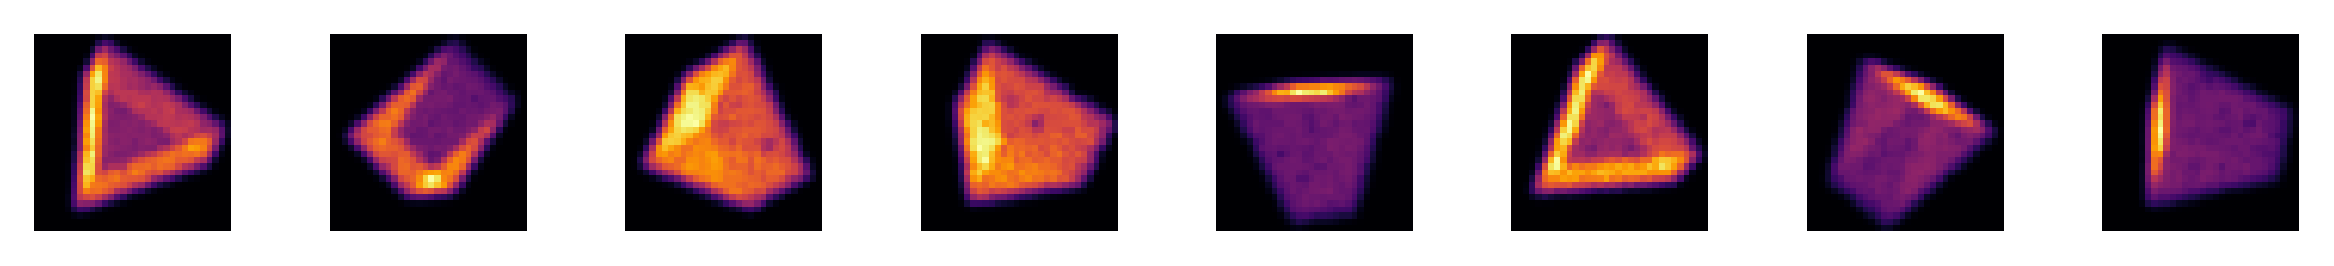

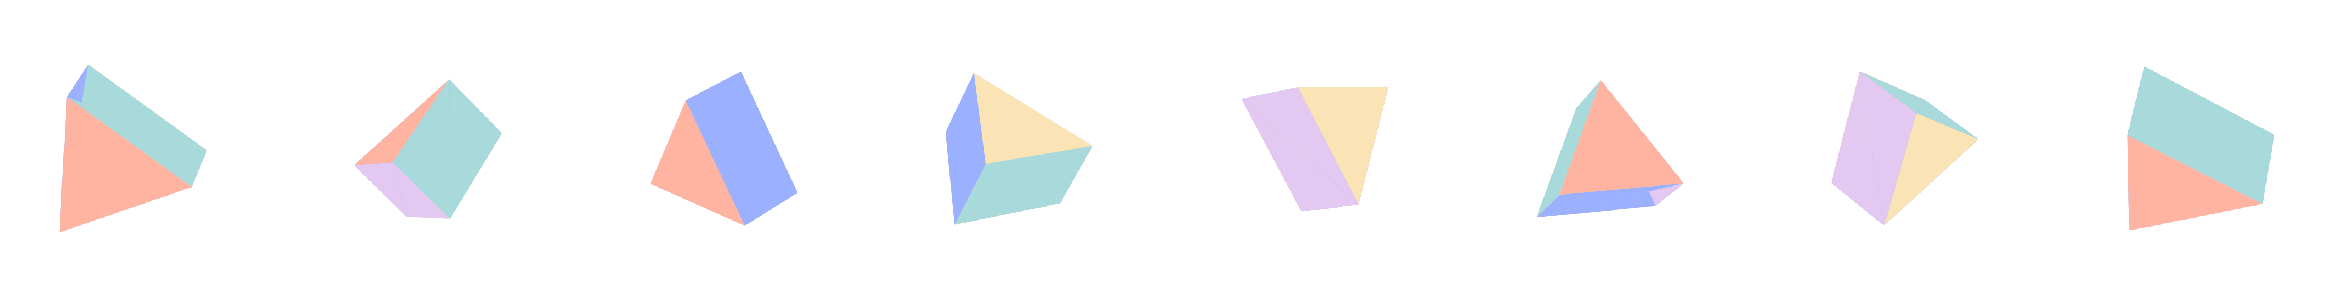

In [3]:
fig = cb.show_data_vis(
    data, 
    vis_density, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first")
plt.show()

fig = cb.show_data_vis(
    mesh_data, 
    vis_mesh, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first", 
    pad_frac=0.3)
plt.show()


$\textbf{Note:}$ 2D projections of the 3D densities are computed by summing intensities along the z-axis, shown here as perpendicular to the screen.  In general, reflecting a rotated prism mesh through the z-axis may produce a very different 3D density, but the 2D projections will appear the same.  On the other hand, two prism meshes which differ by a rotation in the symmetry group of the prism yield indistinguishable 3D densities -- this is a genuine symmetry of the dataset.  

For each 3D density, compute the principal component (up to sign in $\mathbb{RP}^{2}$) associated with the smallest eigenvalue -- for densities in the dataset, this axis is always clearly defined and coincides with the axis of rotational symmetry. Record the $\mathbb{RP}^{2}$ projections as unit vectors in the upper hemisphere of $\mathbb{S}^{2}$:

In [4]:
base_points = cb.get_density_axes(data)

Construct a (good) open cover $\mathcal{U} = \{U_{j}\}_{j=1}^{60}$ of $\mathbb{RP}^{2}$ using a collection of nearly equidistant landmark points (see API reference section):

### Cover And Nerve Summary
- $n_\text{sets} = 60$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 60$
- $\#(\text{1-simplices}) = 177$
- $\#(\text{2-simplices}) = 118$
- *No recorded simplices in dimensions* $\ge 3$

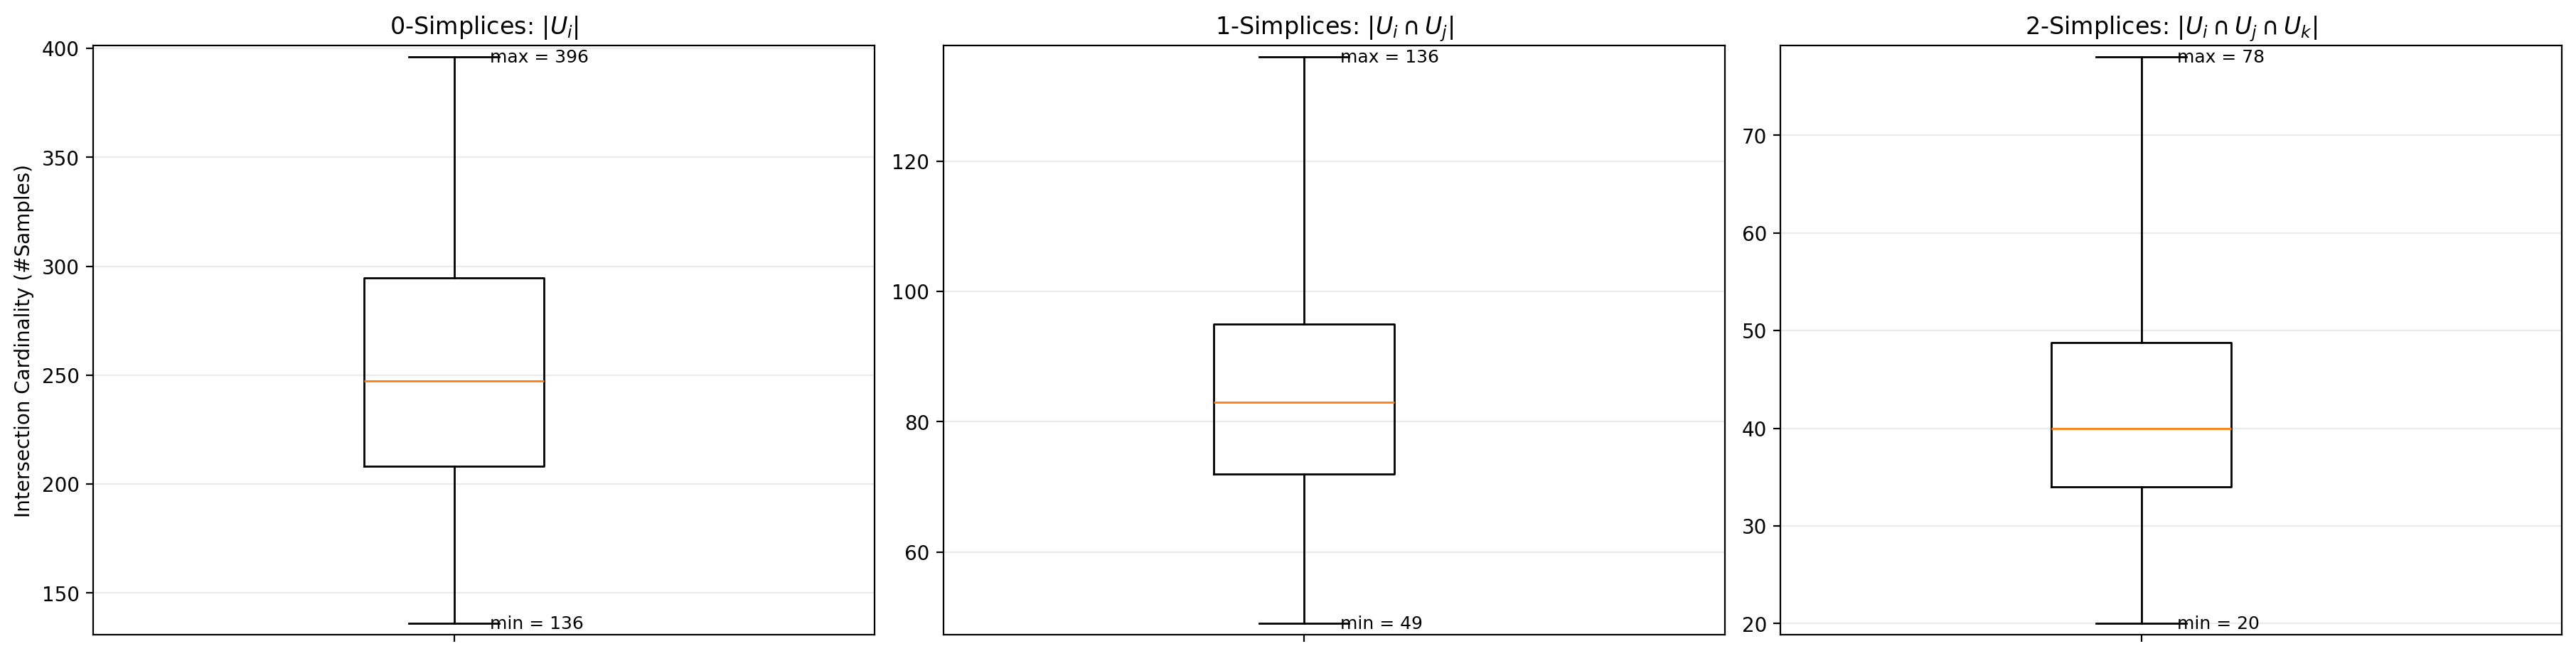

In [5]:
n_landmarks = 60
cover = cb.get_rp2_fibonacci_cover(base_points, n_pairs = n_landmarks)
bundle = cb.Bundle(X = data, cover = cover, show_summary = True)

Observe that the Euler characteristic of $\mathcal{U}$ is $\chi = 60 - 177 + 118 = 1$, as expected for $\mathbb{RP}^{2}$.

Compute a PCA projection for the data in each set $\pi^{-1}(U_{j})$:

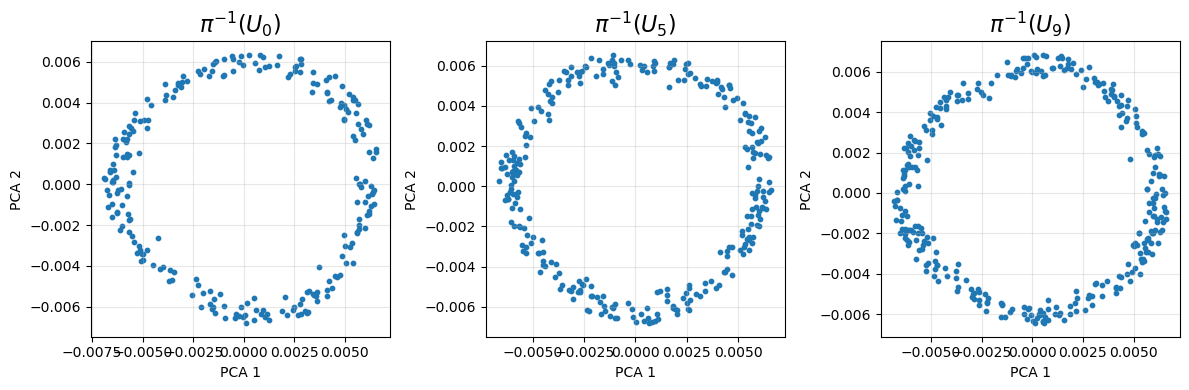

In [6]:
fig, axes = cb.get_local_pca(data, 
                      cover.U,
                      to_view = [0,5,9],
                     )
plt.show()

Show a PCA visualization of a 'fat fiber' of the projection map:

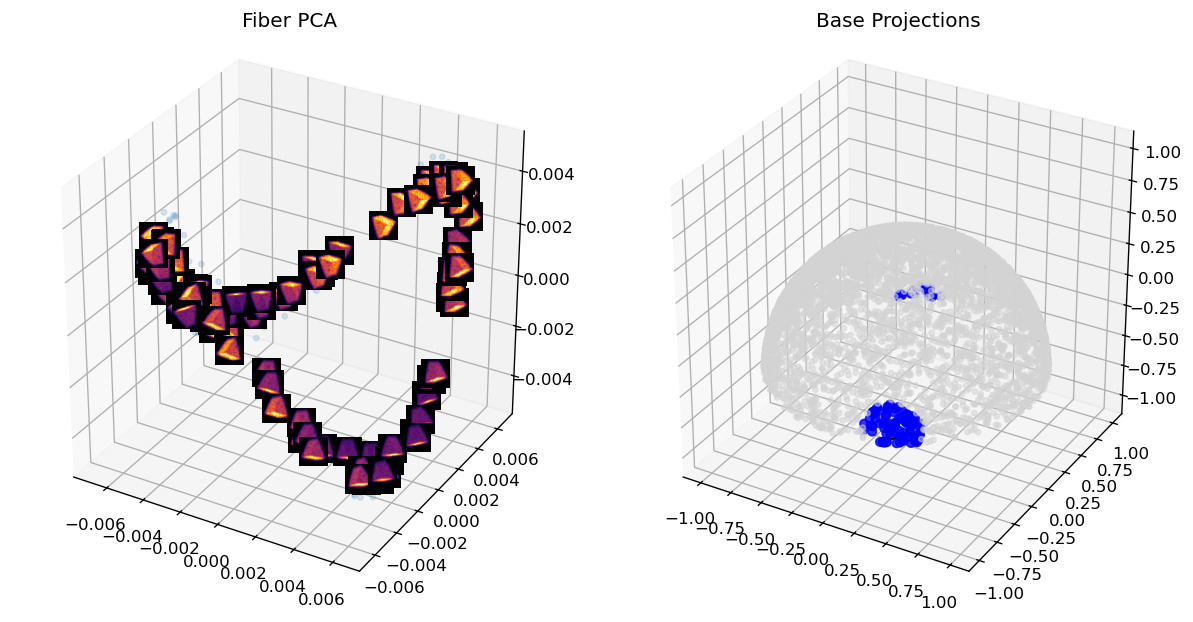

In [9]:
center_ind = 201
r = 0.2
dist_mat = cb.RP2UnitVectorMetric().pairwise(X=base_points)
nearby_indices = np.where(dist_mat[center_ind] < r)[0]

fiber_data = data[nearby_indices]
vis_data = mesh_data[nearby_indices]


fig = plt.figure(figsize=(10, 5), dpi=120)
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

# PCA labeled with density projections
cb.fiber_vis(
    fiber_data,
    vis_func=vis_density,
    max_images=200,
    zoom=0.05,
    ax=ax1,
    show=False,
)
ax1.set_title("Fiber PCA")

# Base visualization
cb.base_vis(
    base_points,
    center_ind,
    r,
    dist_mat,
    ax=ax2,
    show=False,
)
ax2.set_title("Base Projections")

plt.tight_layout()
plt.show()


Construct local circular coordinates using $\text{PCA}_{2}$, then compute approximate transition matrices and characteristic clases:

In [10]:
triv_result = bundle.get_local_trivs()
class_result = bundle.get_classes(show_classes = True, show_persistence = True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Observe that the twisted Euler class becomes trivial as soon as a single edge is removed.  This is to be expected, since the resulting subcomplex deformation retracts onto its 1-skeleton.  On the other hand, the orientation class does not become trivial until many edges are removed. This is also reasonable, since one can show that the restriction of a non-orientable bundle over $\mathbb{RP}^{2}$ to an 'equator' $\mathbb{RP}^{1}$ is still non-orientable (hence non-trivial) -- see below. In any case, the weight of even the heaviest edge is relatively small, suggesting that our model is likely reliable across the entire nerve. 

Show a visualization of the 1-skeleton of the nerve of $\mathcal{U}$.  For readability, each open set is represented by a node with the triangle mesh underlying a representative density. Edges are colored according to the computed orientation class representative (blue for 1 and red for -1):

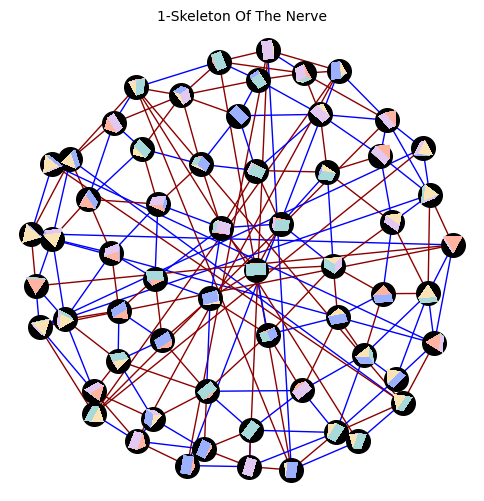

In [11]:
dist_mat = cb.RP2UnitVectorMetric().pairwise(X = cover.landmarks, Y = base_points)
inds = np.argmin(dist_mat, axis = 1)
node_data = mesh_data[inds]

vertex_coords = cover.landmarks[:,:2]
node_labels = [f"{i+1}" for i in range(vertex_coords.shape[0])]

verts = list(range(bundle.n_sets))

edges = bundle.get_simplices(dims=1)

fig, axes = cb.nerve_vis(
    cover.landmarks[:, :2],
    vertices=verts,
    edges=edges,
    cochains={1: class_result.reps.sw1_O1},
    base_colors={0: 'black', 1: 'black', 2: 'pink'},
    cochain_cmaps={1: {1: 'blue', -1: 'darkred'}},
    opacity=0,
    node_size=17,
    line_width=1,
    node_labels=None,
    fontsize=8,
    font_color='white',
    vis_func=vis_mesh,
    data=node_data,
    image_zoom=0.05,
    title='1-Skeleton Of The Nerve',
)



Now, to construct a lower-dimensional representation of the high-dimensional dataset, compute a classifying map to $Gr(2)$ representing the underlying circle bundle and compute the pullback of the canonical circle bundle $V(2)\times_{O(2)}\mathbb{S}^{1}$ (see theory section for details):  

In [12]:
bundle_map_results = bundle.get_bundle_map(packing = 'coloring2')
print(f'Ambient output dimension: {bundle_map_results.F.shape[1]}')

Ambient output dimension: 24


Notice that the pullback data lives in the ambient space $\mathbb{R}^{24}$ (whereas the original dataset lives in $\mathbb{R}^{32768}$). 

Now, consider the data which projects to the 'equator' $\mathbb{RP}^{1}\subset \mathbb{RP}^{2}$:

In [13]:
eps = 0.15  # thickness of equatorial band (in the chosen RP^2 embedding/coords)

# Points near the equator: last coordinate close to 0
eq_mask = np.abs(base_points[:, -1]) < eps
print(f"Equator band: {np.sum(eq_mask)} / {bundle.X.shape[0]} samples (eps={eps}).")


# Parametrize the equator by an angle in RP^1 (theta ~ theta + pi)
eq_base_points = base_points[eq_mask,:2]
eq_base_angles = np.arctan2(eq_base_points[:,1], eq_base_points[:, 0]) % np.pi

#Construct the total space
eq_data = np.concatenate([np.array([np.cos(2*eq_base_angles), np.sin(2*eq_base_angles)]).T, 
                             bundle_map_results.F[eq_mask]],axis = 1)

eq_mesh_data = mesh_data[eq_mask]

Equator band: 697 / 5000 samples (eps=0.15).


In [40]:
n_landmarks = 20
lmk_angs = np.linspace(0, np.pi, n_landmarks, endpoint=False)
landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
overlap = 1.4
radius = overlap * np.pi / (2*n_landmarks)

eq_cover = cb.get_metric_ball_cover(
    np.array([np.cos(eq_base_angles), np.sin(eq_base_angles)]).T, 
    landmarks, 
    radius = radius, 
    metric = cb.RP1UnitVectorMetric()
)

eq_bundle = cb.Bundle(X = eq_data, cover = eq_cover)
eq_local_triv_result = eq_bundle.get_local_trivs()
eq_class_result = eq_bundle.get_classes(show_classes = True)

<IPython.core.display.Math object>

The characteristic classes confirm that the restricted pullback dataset has the topology of a Klein bottle embedded in $\mathbb{R}^{26}$.

Compute a global 'coordinate system' for the restricted dataset after dropping the heaviest edge from the nerve of the cover of $\mathbb{RP}^{1}$, then show a visualization of the coordinatized densities, represented by both the corresponding triangle meshes and 2D projections of the densities themselves:

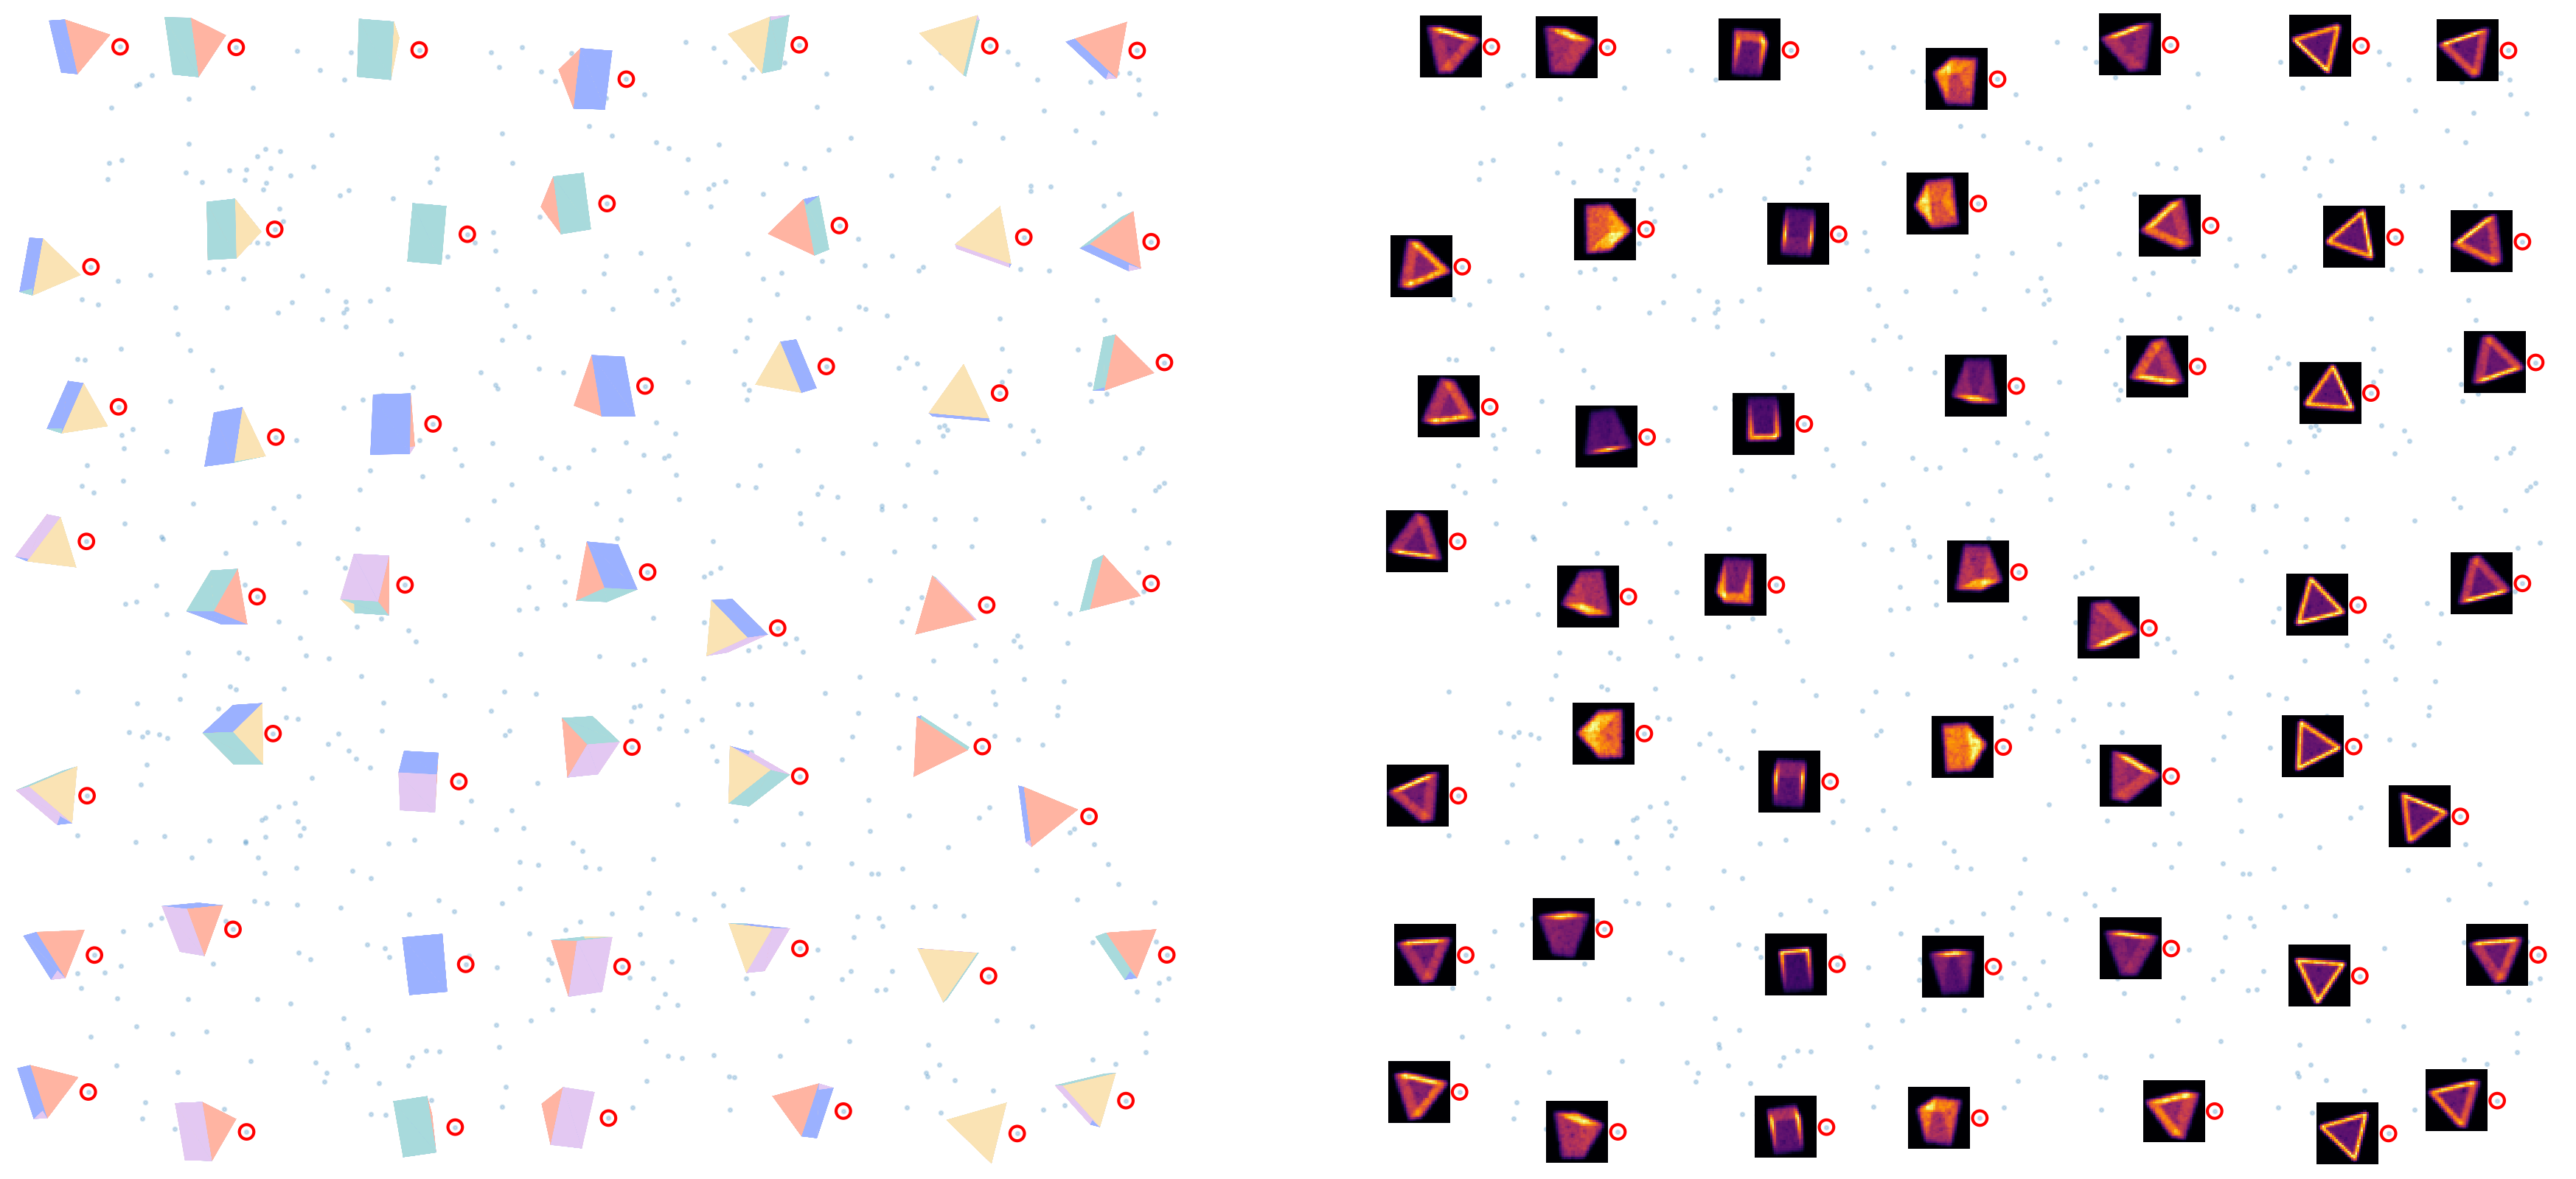

In [39]:
eq_fiber_angles = eq_bundle.get_global_trivialization()

#Apply a translation to the base coordinate so the cut is at the edge of the diagram
vertex_dist = np.pi/n_landmarks
shift = -1*(radius + 2*vertex_dist)
shifted_angles = (eq_base_angles + shift) % (np.pi)
coords = np.column_stack([shifted_angles, eq_fiber_angles])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), dpi=200)

cb.scatter_lattice_vis(
    eq_mesh_data, 
    coords, 
    vis_mesh, 
    per_row = 7, 
    per_col = 7,
    padding = 0,
    ax = ax1,
    point_alpha = 0.2
)

cb.scatter_lattice_vis(
    data[eq_mask], 
    coords, 
    vis_density, 
    per_row = 7, 
    per_col = 7,
    padding = 0,
    ax = ax2,
    point_alpha = 0.2
)

plt.show()

Notice that base projection roughly corresponds to axis of symmetry, as expected.  Upon careful inspection, one can see that coordinatized densities in each column approximately traverse a 1/3 rotation about the axis of symmetry, though the direction of rotation differs in the first and last column (where the cut was made). The top and bottom rows of the diagram roughly coincide, and the first and last columns roughly differ by a reflection. This encapsulates the Klein bottle topology. 